# Yelp Business Reviews - Sentiment Analysis

## Importing Libraries (will be edited)

In [314]:
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import findspark
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import IDF, StopWordsRemover, Tokenizer, VectorAssembler, CountVectorizer
from pyspark.ml.linalg import Vector
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, lit, lower, regexp_replace, size, split, filter, udf, sum
from pyspark.sql.functions import when
from pyspark.sql.types import ArrayType,StringType, FloatType, StructType, StructField
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.functions import vector_to_array

StatementMeta(sparkpool, 20, 46, Finished, Available)

## Creating Spark Session

In [190]:
""" UNCOMMENT WHEN RUNNING ON LOCAL !!!
# Create a spark session
findspark.init()
spark = SparkSession.builder \
    .appName("Yelp_Sentiment_Analysis") \
    .master("local[8]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

### Patlarsa dene
#.config("spark.memory.offHeap.enabled","true") 
#.config("spark.memory.offHeap.size","10g")
"""

StatementMeta(sparkpool, 18, 36, Finished, Available)

' UNCOMMENT WHEN RUNNING ON LOCAL !!!\n# Create a spark session\nfindspark.init()\nspark = SparkSession.builder     .appName("Yelp_Sentiment_Analysis")     .master("local[8]")     .config("spark.executor.memory", "10g")     .config("spark.executor.cores", "3")     .config("spark.driver.memory", "2g")     .getOrCreate()\n\n### Patlarsa dene\n#.config("spark.memory.offHeap.enabled","true") \n#.config("spark.memory.offHeap.size","10g")\n'

In [315]:
# Get config
conf = spark.sparkContext.getConf()

# Print the configuration settings
print("spark.app.name = ", conf.get("spark.app.name"))
print("spark.master = ", conf.get("spark.master"))
print("spark.executor.memory = ", conf.get("spark.executor.memory"))
print("spark.executor.cores = ", conf.get("spark.executor.cores")),
print("spark.driver.memory = ", conf.get("spark.driver.memory"))

StatementMeta(sparkpool, 20, 47, Finished, Available)

spark.app.name =  Yelp_Sentiment_Analysis_sparkpool_1710949780
spark.master =  yarn
spark.executor.memory =  28g
spark.executor.cores =  4
spark.driver.memory =  28g


In [192]:
"""
# Source file pathways on local disk
path_business = "../yelp_academic_dataset_business.json"
path_review = "../yelp_academic_dataset_review.json"
positive_path = "../positive_words.txt"
negative_path = "../negative_words.txt"
"""

StatementMeta(sparkpool, 18, 38, Finished, Available)

'\n# Source file pathways on local disk\npath_business = "../yelp_academic_dataset_business.json"\npath_review = "../yelp_academic_dataset_review.json"\npositive_path = "../positive_words.txt"\nnegative_path = "../negative_words.txt"\n'

In [316]:

# Source file pathways on ABFSS
path_business = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/yelp_academic_dataset_business.json"
path_review = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/yelp_academic_dataset_review.json"
positive_path = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/positive_words.txt"
negative_path = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/negative_words.txt"


StatementMeta(sparkpool, 20, 48, Finished, Available)

## Preprocessing of Business Dataset

In [317]:
# Import business data
business = spark.read.json(path_business)

StatementMeta(sparkpool, 20, 49, Finished, Available)

In [318]:
# Print first 10 rows
business.show(n=10, truncate=10)

StatementMeta(sparkpool, 20, 50, Finished, Available)

+----------+----------+-----------+----------+----------+----------+-------+----------+----------+----------+-----------+------------+-----+-----+
|   address|attributes|business_id|categories|      city|     hours|is_open|  latitude| longitude|      name|postal_code|review_count|stars|state|
+----------+----------+-----------+----------+----------+----------+-------+----------+----------+----------+-----------+------------+-----+-----+
|1616 Ch...|{null, ...| Pns2l4e...|Doctors...|Santa B...|      null|      0|34.4266787|-119.71...|Abby Ra...|      93101|           7|  5.0|   CA|
|87 Gras...|{null, ...| mpf3x-B...|Shippin...|    Affton|{8:0-18...|      1| 38.551126|-90.335695|The UPS...|      63123|          15|  3.0|   MO|
|5255 E ...|{null, ...| tUFrWir...|Departm...|    Tucson|{8:0-23...|      0| 32.223236|-110.88...|    Target|      85711|          22|  3.5|   AZ|
|935 Rac...|{null, ...| MTSW4Mc...|Restaur...|Philade...|{7:0-21...|      1|39.9555052|-75.155...|St Hono...|      191

In [319]:
business = business.drop('attributes','hours')

StatementMeta(sparkpool, 20, 51, Finished, Available)

In [320]:
# Print current dataset schema
business.printSchema()

StatementMeta(sparkpool, 20, 52, Finished, Available)

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)



In [321]:
# Filter out rows with null 'categories'
business = business.filter(col("categories").isNotNull())

StatementMeta(sparkpool, 20, 53, Finished, Available)

In [322]:
# Filter for businesses in US states
states = [ "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS",\
 "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", ]

usa = business.filter(col("state").isin(states))

StatementMeta(sparkpool, 20, 54, Finished, Available)

In [323]:
# Print out the total number of businesses in dataset
print(f"Number of US businesses in the dataset: {usa.count()}")

StatementMeta(sparkpool, 20, 55, Finished, Available)

Number of US businesses in the dataset: 144669


In [324]:
# Filter restaurants and print out the total number
us_restaurants = usa.filter(usa["categories"].contains("Restaurants"))
print(f"Number of total US restaurants in the dataset: {us_restaurants.count()}")

StatementMeta(sparkpool, 20, 56, Finished, Available)

Number of total US restaurants in the dataset: 49857


In [325]:
# Label every row with their respective type of cuisine
us_restaurants = us_restaurants.withColumn(
    "category",
    when(col("categories").contains("Korean"), "Korean")
    .when(col("categories").contains("Thai"), "Thai")
    .when(col("categories").contains("French"), "French")
    .when(col("categories").contains("Greek"), "Greek")
    .when(col("categories").contains("Indian"), "Indian")
    .when(col("categories").contains("Hawaiian"), "Hawaiian")
    .when(col("categories").contains("African"), "African")
    .when(col("categories").contains("Spanish"), "Spanish")
)

StatementMeta(sparkpool, 20, 57, Finished, Available)

In [326]:
# Drop the old category column and filter out null categories
us_restaurants = us_restaurants.drop("categories")
us_restaurants = us_restaurants.filter(col("category").isNotNull())

StatementMeta(sparkpool, 20, 58, Finished, Available)

In [327]:
# Print out the number of restaurants that are labeled by their cuisine types
print(f"Number of labeled US restaurants in the dataset: {us_restaurants.count()}")

StatementMeta(sparkpool, 20, 59, Finished, Available)

Number of labeled US restaurants in the dataset: 3819


In [285]:
# Check if the dataset contains any duplicated businesses
us_restaurants.groupBy("business_id").count().filter(col("count") > 1).count()

StatementMeta(sparkpool, 20, 17, Finished, Available)

0

In [328]:
us_restaurants.show(5)

StatementMeta(sparkpool, 20, 60, Finished, Available)

+--------------------+--------------------+---------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------+
|             address|         business_id|           city|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|category|
+--------------------+--------------------+---------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------+
|   8025 Mackenzie Rd|k0hlBqXX-Bt0vf1op...|         Affton|      0|   38.5651648|   -90.3210868|Tsevi's Pub And G...|      63123|          19|  3.0|   MO|   Greek|
|       1224 South St|ROeacJQwBeh05Rqg7...|   Philadelphia|      1|    39.943223|    -75.162568|                 BAP|      19147|         205|  4.5|   PA|  Korean|
|       163 107th Ave|vje0KIiE7vtpx7Jzm...|Treasure Island|      1|   27.7694046|    -82.767317|           The Pearl|      33706|         129|  4.0|   FL|  French|
|2E Summit Sq Sh

## Preprocessing of Review Dataset

In [329]:
# Import review data
review = spark.read.json(path_review)

StatementMeta(sparkpool, 20, 61, Finished, Available)

In [330]:
# Print first 10 rows
review.show(n=10, truncate=20)

StatementMeta(sparkpool, 20, 62, Finished, Available)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [331]:
review = review.select('business_id','text','stars')

StatementMeta(sparkpool, 20, 63, Finished, Available)

In [332]:
# Print current dataset schema
review.printSchema()

StatementMeta(sparkpool, 20, 64, Finished, Available)

root
 |-- business_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- stars: double (nullable = true)



## Merging Business and Review Datasets

In [333]:
# Change the names of 'stars' columns in both datasets to avoid confusion
us_restaurants = us_restaurants.withColumnRenamed("stars", "avg_star")
review = review.withColumnRenamed("stars", "review_star")

StatementMeta(sparkpool, 20, 65, Finished, Available)

In [334]:
# Merge the dataframes on 'business_id'
restaurants_reviews = us_restaurants.join(review, on="business_id", how="inner")

StatementMeta(sparkpool, 20, 66, Finished, Available)

In [335]:
# Print the schema of merged dataframe
restaurants_reviews.printSchema()

StatementMeta(sparkpool, 20, 67, Finished, Available)

root
 |-- business_id: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- avg_star: double (nullable = true)
 |-- state: string (nullable = true)
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)
 |-- review_star: double (nullable = true)



## Preprocessing of Restaurants_Reviews Dataset

In [336]:
# Create a 'labels' column
# 4-5 Stars --> Positive
# 3 Stars --> Neutral
# 1-2 Stars --> Negative
restaurants_reviews = restaurants_reviews.withColumn(
    "labels",
    when(restaurants_reviews["review_star"] >= 4, "positive")
    .when(restaurants_reviews["review_star"] == 3, "neutral")
    .when(restaurants_reviews["review_star"] < 3, "negative"),
)

StatementMeta(sparkpool, 20, 68, Finished, Available)

In [337]:
# Filter out neutral reviews and count the rest
restaurants_reviews = restaurants_reviews.where(
    restaurants_reviews["labels"] != "neutral"
)
print(f'The number of positive and negative reviews : {restaurants_reviews.count()}')

StatementMeta(sparkpool, 20, 69, Finished, Available)

The number of positive and negative reviews : 419726


In [338]:
# Show the distribution of reviews by category
restaurants_reviews.groupBy('category').count().sort('count',ascending = False).show()

StatementMeta(sparkpool, 20, 70, Finished, Available)

+--------+-----+
|category|count|
+--------+-----+
|    Thai|99373|
|  French|81571|
|  Indian|66369|
|   Greek|63339|
|  Korean|48354|
| Spanish|33161|
|Hawaiian|21394|
| African| 6165|
+--------+-----+



## Data Transformation on Reviews

In [339]:
# Show 'text' column before transformation
restaurants_reviews.select("text").show(10, truncate=80)

StatementMeta(sparkpool, 20, 71, Finished, Available)

+--------------------------------------------------------------------------------+
|                                                                            text|
+--------------------------------------------------------------------------------+
|Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korm...|
|I am a long term frequent customer of this establishment. I just went in to o...|
|I was really between 3 and 4 stars for this one. I LOVE the 96th street Naked...|
|Best thai food in the area.  Everything was authentic and delicious.  Will de...|
|It was my fiance's birthday and he decided he wanted a good, laid back Thai r...|
|My go to menu is coconut soup and pad thai with protein. I tried same menu he...|
|Been here so many times before and all I can say is the food is really good. ...|
|This is the first time I tried this place and  I was surprisingly surprised. ...|
|I must admit, I wasn't expecting much. This place totally blew us away. This ...|
|We 

In [340]:
# Convert 'text' to lowercase
restaurants_reviews = restaurants_reviews.withColumn("text", F.lower(F.col("text")))

StatementMeta(sparkpool, 20, 72, Finished, Available)

In [341]:
# Transform review text by using regular expressions

# Replace all non-alphanumeric characters with a whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text"), "[^a-zA-Z0-9\s]", " ")
)

# Replace all line break character with a whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\n", " ")
)

# Replace all consecutive whitespaces with a single whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\\s+", " ")
)

# Delete all whitespace characters at the end of each string.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\s+$", "")
)

StatementMeta(sparkpool, 20, 73, Finished, Available)

In [342]:
# Show 'text_clean' column after transformation
restaurants_reviews.select("text_clean").show(10, truncate=50)

StatementMeta(sparkpool, 20, 74, Finished, Available)

+--------------------------------------------------+
|                                        text_clean|
+--------------------------------------------------+
|wow yummy different delicious our favorite is t...|
|i am a long term frequent customer of this esta...|
|i was really between 3 and 4 stars for this one...|
|best thai food in the area everything was authe...|
|it was my fiance s birthday and he decided he w...|
|my go to menu is coconut soup and pad thai with...|
|been here so many times before and all i can sa...|
|this is the first time i tried this place and i...|
|i must admit i wasn t expecting much this place...|
|we have been here twice for brunch and have enj...|
+--------------------------------------------------+
only showing top 10 rows



In [343]:
restaurants_reviews = restaurants_reviews.withColumn('labels_bool', when(col('labels') == 'positive' , 1).otherwise(0))

StatementMeta(sparkpool, 20, 75, Finished, Available)

In [344]:
restaurants_reviews.show(5)

StatementMeta(sparkpool, 20, 76, Finished, Available)

+--------------------+--------------------+------------+-------+-------------+--------------+--------------------+-----------+------------+--------+-----+--------+--------------------+-----------+--------+--------------------+-----------+
|         business_id|             address|        city|is_open|     latitude|     longitude|                name|postal_code|review_count|avg_star|state|category|                text|review_star|  labels|          text_clean|labels_bool|
+--------------------+--------------------+------------+-------+-------------+--------------+--------------------+-----------+------------+--------+-----+--------+--------------------+-----------+--------+--------------------+-----------+
|kxX2SOes4o-D3ZQBk...|      2481 Grant Ave|Philadelphia|      1|40.0798480557| -75.025079772|               Zaika|      19114|         181|     4.0|   PA|  Indian|wow!  yummy, diff...|        5.0|positive|wow yummy differe...|          1|
|04UD14gamNjLY0IDY...|        795 S 3rd St|P

## Positive and Negative Words

In [345]:
# There are 2 .txt files in the main directory where positive and negative words in English language are collected.
# Mentioned text files will be used to evaluate whether a word is positive or negative.

# Read text files and create RDDs
positive_rdd = spark.sparkContext.textFile(positive_path)
negative_rdd = spark.sparkContext.textFile(negative_path)

# Convert RDDs into lists
positive_words = positive_rdd.collect()
negative_words = negative_rdd.collect()

# Create lists with useless words that doesn't give any valuable info about restaurants.
positive_useless = [ "great", "amazing", "love", "best", "awesome", "excellent", "good", "favorite", "loved", "perfect", "gem", "perfectly",
"wonderful", "happy", "enjoyed", "nice", "well", "super", "like", "better", "decent", "fine", "pretty", "enough", "excited", "impressed", 
"ready", "fantastic", "glad", "right", "fabulous", ]
negative_useless = [ "bad", "disappointed", "unfortunately", "disappointing", "horrible", "lacking", "terrible", "sorry", "disappoint", "worst", ]

# Filter useless words out
positive_words = [x for x in positive_words if x not in positive_useless]
negative_words = [x for x in negative_words if x not in negative_useless]

# Print first 10 elements of lists
print(positive_words[:10])
print(negative_words[:10])

StatementMeta(sparkpool, 20, 77, Finished, Available)

['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade']
['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade']


In [346]:
def filter_words(col):
    """ Splits into a list and filter out the words that are not in positive or negative word list."""
    
    text = [i for i in col.split() if i in positive_words + negative_words]
   
    return text

StatementMeta(sparkpool, 20, 78, Finished, Available)

In [347]:
restaurants_reviews = restaurants_reviews.withColumn("text_filtered", udf(filter_words, returnType=ArrayType(StringType()))(col("text_clean")))

StatementMeta(sparkpool, 20, 79, Finished, Available)

In [348]:
restaurants_reviews.show(3,truncate = 20)

StatementMeta(sparkpool, 20, 80, Finished, Available)

+--------------------+--------------------+------------+-------+-------------+-------------+--------------------+-----------+------------+--------+-----+--------+--------------------+-----------+--------+--------------------+-----------+--------------------+
|         business_id|             address|        city|is_open|     latitude|    longitude|                name|postal_code|review_count|avg_star|state|category|                text|review_star|  labels|          text_clean|labels_bool|       text_filtered|
+--------------------+--------------------+------------+-------+-------------+-------------+--------------------+-----------+------------+--------+-----+--------+--------------------+-----------+--------+--------------------+-----------+--------------------+
|kxX2SOes4o-D3ZQBk...|      2481 Grant Ave|Philadelphia|      1|40.0798480557|-75.025079772|               Zaika|      19114|         181|     4.0|   PA|  Indian|wow!  yummy, diff...|        5.0|positive|wow yummy differe..

In [349]:
#Drop unnecessary columns
restaurants_reviews = restaurants_reviews.select(['category','text_filtered','labels_bool'])

StatementMeta(sparkpool, 20, 81, Finished, Available)

In [350]:
#Print the schema
restaurants_reviews.printSchema()

StatementMeta(sparkpool, 20, 82, Finished, Available)

root
 |-- category: string (nullable = true)
 |-- text_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- labels_bool: integer (nullable = false)



In [351]:
restaurants_reviews.show(3)

StatementMeta(sparkpool, 20, 83, Finished, Available)

+--------+--------------------+-----------+
|category|       text_filtered|labels_bool|
+--------+--------------------+-----------+
|  Indian|[wow, delicious, ...|          1|
|   Greek|        [dick, fuck]|          0|
|Hawaiian|[consistently, sl...|          1|
+--------+--------------------+-----------+
only showing top 3 rows



In [305]:
#Cache the processed DataFrame
restaurants_reviews.cache()
restaurants_reviews.storageLevel

StatementMeta(sparkpool, 20, 37, Finished, Available)

StorageLevel(True, True, False, True, 1)

In [352]:
restaurants_reviews.count()

StatementMeta(sparkpool, 20, 84, Finished, Available)

419726

In [359]:
def get_polarity(category):
    
    df = restaurants_reviews.filter(col("category") == category)
    df = df.select(['text_filtered','labels_bool'])
    #df.cache()
    print(df.storageLevel)

    vectorizer = CountVectorizer(inputCol = 'text_filtered', outputCol = 'vector')
    vectorizer_model = vectorizer.fit(df)
    vocab = vectorizer_model.vocabulary
    df = vectorizer_model.transform(df)
    print('1')
    lr = LogisticRegression(featuresCol = 'vector', labelCol = 'labels_bool')
    lr_model = lr.fit(df)
    coeff = lr_model.coefficients
    coeff = [float(i) for i in coeff]
    print('2')
    vector_dense_arr = vector_to_array(df.vector)
    df = df.withColumn('vector_dense',vector_dense_arr)
    vector_dense_rdd = df.select('vector_dense').rdd
    vec = vector_dense_rdd.collect()
    vec = list(map(lambda x: x[0],vec))
    print('3')
    schema = StructType(
    [StructField(i,FloatType(),False) for i in vocab]
    )
    matrix = spark.createDataFrame(vec,schema = schema)
    matrix_pd = matrix.toPandas()
    print('4')
    freq_series = matrix_pd.sum(axis = 0)
    freq_rdd = sc.parallelize(freq_series)
    freq = freq_rdd.collect()
    print('5')
    word_coeff_freq = [(i,j,k) for (i,j,k) in zip(vocab,coeff,freq)]
    word_coeff_freq_df = spark.createDataFrame(word_coeff_freq, ['word','coeff','freq'])
    print('6')
    n = matrix.count()
    master_df = word_coeff_freq_df.withColumn('polarity', col('coeff') * col('freq') / n)
    print('7')
    positive_10 = master_df.sort('polarity',ascending = False).head(10)
    negative_10 = master_df.sort('polarity',ascending = True).head(10)
    positive_10_pd = pd.DataFrame(positive_10, columns = master_df.columns)
    negative_10_pd = pd.DataFrame(negative_10, columns = master_df.columns)
    print('8')
    negative_10_pd = negative_10_pd.sort_values('polarity',ascending = False)
    print('9')
    sum_df = pd.concat([positive_10_pd,negative_10_pd])
    print('10')
    return sum_df

StatementMeta(sparkpool, 20, 91, Finished, Available)

In [366]:
def get_plot(sum_df,category):
    sns.set_style('darkgrid')
    sns.set_context('notebook')
    fig,ax = plt.subplots(figsize = (9,6))
    sns.barplot(data = sum_df, x = 'polarity' , y = 'word',palette = 'RdBu_r')
    plt.title("The Most Effective Words in " + category + " Restaurants's Reviews")
    plt.xlabel('Polarity Score')
    plt.ylabel('Word')
    plt.xlim(sum_df['polarity'].min(),sum_df['polarity'].max())
    plt.show()


StatementMeta(sparkpool, 20, 98, Finished, Available)

In [ ]:
african_df = get_polarity('African')

In [363]:
african_df.head(20)

StatementMeta(sparkpool, 20, 95, Finished, Available)

,word,coeff,freq,polarity
0,delicious,3.514213,1514.0,0.863020
1,friendly,1.614540,925.0,0.242247
2,phenomenal,14.140374,79.0,0.181199
3,romantic,34.296216,26.0,0.144639
4,recommend,1.110986,766.0,0.138040
5,enjoying,14.766156,51.0,0.122153
6,outstanding,8.706570,84.0,0.118630
7,perfection,7.139910,95.0,0.110023
8,delightful,14.429629,45.0,0.105326
9,generous,5.320732,112.0,0.096662


StatementMeta(sparkpool, 20, 102, Finished, Available)

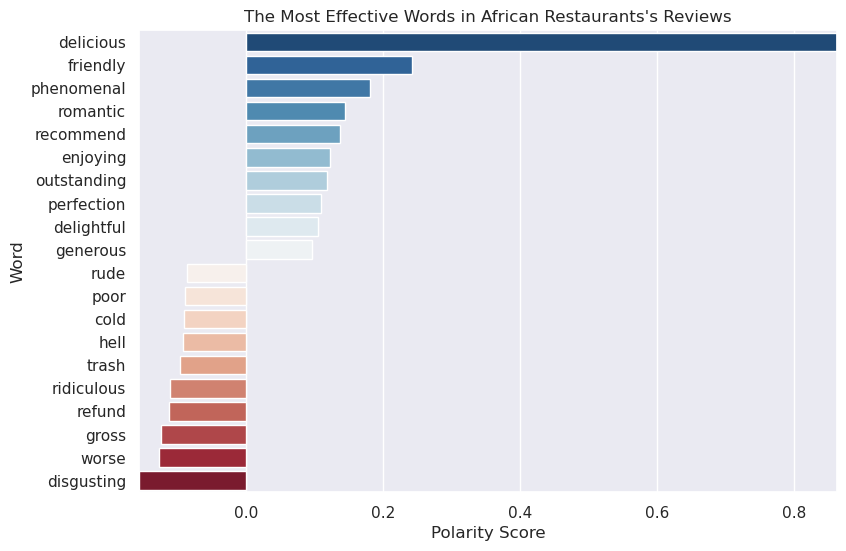

In [370]:
get_plot(african_df,'African')

In [371]:
hawaiian_sum_df =get_polarity('Hawaiian')

StatementMeta(sparkpool, 20, 103, Finished, Available)

Serialized 1x Replicated
1
2
3
4
5
6
7
8
9
10


In [373]:
hawaiian_sum_df.head(25)

StatementMeta(sparkpool, 20, 105, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.786398,5128.0,0.667881
1,fresh,1.549208,5426.0,0.392914
2,friendly,1.031693,4075.0,0.196511
3,recommend,0.923712,2343.0,0.101162
4,fun,2.360756,738.0,0.081436
5,attentive,2.588746,593.0,0.071755
6,stumbled,16.619485,83.0,0.064477
7,incredible,3.220786,378.0,0.056906
8,clean,0.818329,1431.0,0.054736
9,fast,0.913560,1242.0,0.053035


StatementMeta(sparkpool, 20, 104, Finished, Available)

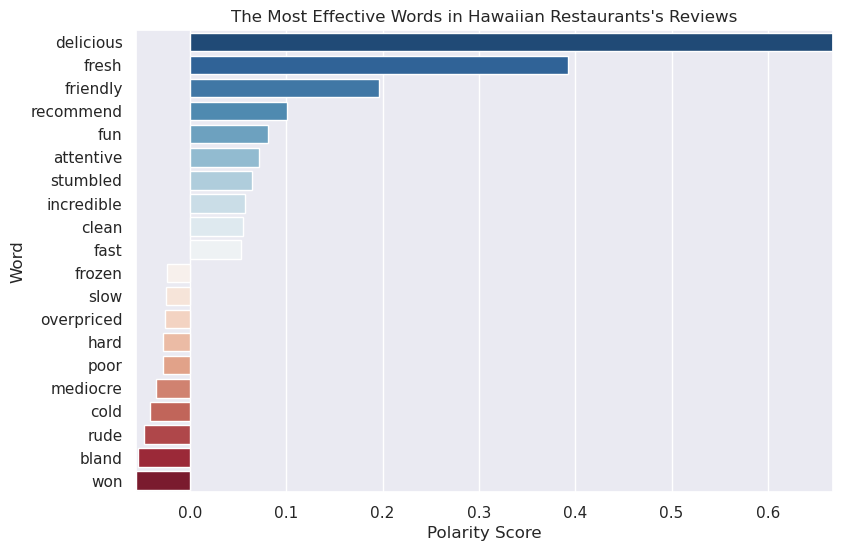

In [372]:
get_plot(hawaiian_sum_df,'Hawaiian')

In [374]:
restaurants_reviews.cache()
restaurants_reviews.storageLevel

StatementMeta(sparkpool, 20, 106, Finished, Available)

StorageLevel(True, True, False, True, 1)

In [375]:
spanish_sum_df = get_polarity('Spanish')

StatementMeta(sparkpool, 20, 107, Finished, Cancelled)

Serialized 1x Replicated


In [376]:
restaurants_reviews.unpersist()
restaurants_reviews.storageLevel

StatementMeta(sparkpool, 20, 108, Finished, Available)

StorageLevel(False, False, False, False, 1)

In [377]:
spanish_sum_df = get_polarity('Spanish')

StatementMeta(sparkpool, 20, 109, Finished, Available)

Serialized 1x Replicated
1
2
3
4
5
6
7
8
9
10


In [378]:
spanish_sum_df.head(25)

StatementMeta(sparkpool, 20, 110, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.251690,9584.0,0.650770
1,friendly,1.132263,4214.0,0.143885
2,recommend,0.759141,4303.0,0.098507
3,outstanding,3.358494,914.0,0.092568
4,incredible,2.581753,1003.0,0.078089
5,fresh,0.728280,3432.0,0.075373
6,authentic,1.030783,2229.0,0.069287
7,downside,20.149373,113.0,0.068661
8,fun,1.564154,1326.0,0.062545
9,perfection,2.652211,683.0,0.054626


StatementMeta(sparkpool, 20, 111, Finished, Available)

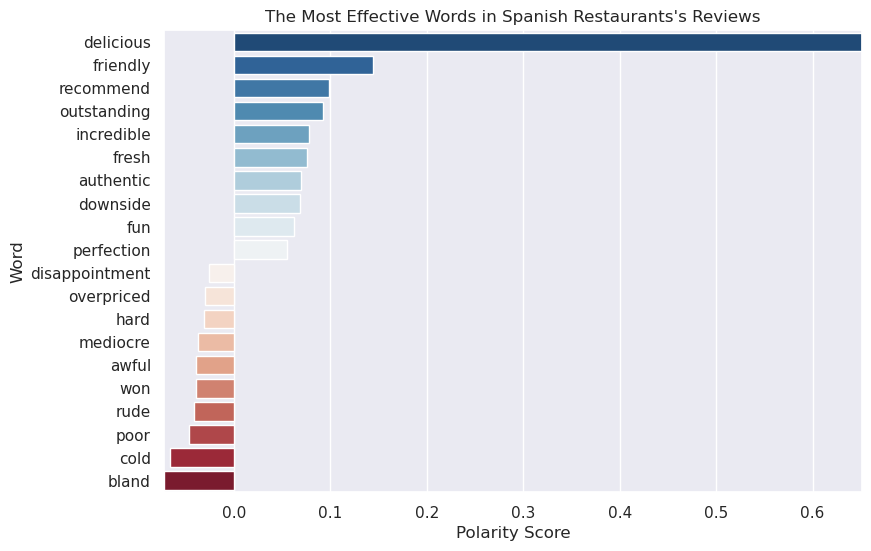

In [379]:
get_plot(spanish_sum_df,'Spanish')

After this point, all the processes will be implemented for 'African' restaurants.

In [308]:
# Define a function that filters rows based on the 'category' parameter
def get_dataset(category):
    """Takes in a category name as string. Returns a DataFrame with filtered rows based on category argument."""

    # Filter DataFrame to only include reviews for the given category
    df = restaurants_reviews.filter(col("category") == category)

    # Select relevant columns
    df = df.select(["text_filtered","labels_bool"])

    return df

StatementMeta(sparkpool, 20, 40, Finished, Available)

In [309]:
African = get_dataset("African")

StatementMeta(sparkpool, 20, 41, Finished, Available)

In [310]:
African.show(5, truncate = 40)

StatementMeta(sparkpool, 20, 42, Finished, Cancelled)

In [311]:
African.dtypes

StatementMeta(sparkpool, 20, 43, Finished, Available)

[('text_filtered', 'array<string>'), ('labels_bool', 'int')]

In [312]:
vectorizer = CountVectorizer(inputCol = 'text_filtered', outputCol = 'vector')

# Fit the CountVectorizer object to the training data
vectorizer_model = vectorizer.fit(African)

StatementMeta(sparkpool, 20, 44, Finished, Cancelled)

In [27]:
vocab = vectorizer_model.vocabulary
vocab[:10]

StatementMeta(sparkpool, 17, 28, Finished, Available)

['delicious',
 'friendly',
 'recommend',
 'fried',
 'fresh',
 'sweet',
 'worth',
 'hot',
 'enjoy',
 'beautiful']

In [28]:
African_df = vectorizer_model.transform(African)

StatementMeta(sparkpool, 17, 29, Finished, Available)

In [31]:
African_df.show(5,truncate = 80)

StatementMeta(sparkpool, 16, 32, Finished, Available)

+--------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----------+
|  labels|                                                                   text_filtered|                                                                          vector|labels_bool|
+--------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----------+
|positive|                                                                      [friendly]|                                                                (1973,[1],[1.0])|          1|
|positive|                                                                         [rusty]|                                                               (1973,[24],[1.0])|          1|
|positive|[fresh, dedicated, gained, enjoy, enjoy, beautiful, awful, cozy, 

In [30]:
lr = LogisticRegression(featuresCol = 'vector', labelCol = 'labels_bool')
lr_model = lr.fit(African_df)

StatementMeta(sparkpool, 17, 31, Finished, Available)

In [31]:
coeff = lr_model.coefficients
coeff = [float(i) for i in coeff]
coeff[:10]


StatementMeta(sparkpool, 17, 32, Finished, Available)

[3.5142131519065587,
 1.6145403134708656,
 1.1109860864823224,
 0.1576573331590272,
 0.6378908147176446,
 0.6598956823469534,
 0.4010368793251726,
 0.8482240452829103,
 -0.3834754860223588,
 0.02819239682736559]

In [32]:
word_coeff = [(i,j) for (i,j) in zip(vocab,coeff)]
word_coeff[:5]

StatementMeta(sparkpool, 17, 33, Finished, Available)

[('delicious', 3.5142131519065587),
 ('friendly', 1.6145403134708656),
 ('recommend', 1.1109860864823224),
 ('fried', 0.1576573331590272),
 ('fresh', 0.6378908147176446)]

In [33]:
word_coeff_df = spark.createDataFrame(word_coeff,['word','coeff'])
word_coeff_df.show(5)

StatementMeta(sparkpool, 17, 34, Finished, Available)

+---------+------------------+
|     word|             coeff|
+---------+------------------+
|delicious|3.5142131519065587|
| friendly|1.6145403134708656|
|recommend|1.1109860864823224|
|    fried|0.1576573331590272|
|    fresh|0.6378908147176446|
+---------+------------------+
only showing top 5 rows



In [34]:
African_df.select('vector').show(5, truncate = 100)

StatementMeta(sparkpool, 17, 35, Finished, Available)

+----------------------------------------------------------------------------------------+
|                                                                                  vector|
+----------------------------------------------------------------------------------------+
|                                                                        (1973,[1],[1.0])|
|                                                                       (1973,[24],[1.0])|
|(1973,[4,6,8,9,53,58,69,80,832,1658,1720],[1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|                 (1973,[6,17,18,135,143,166,186,1757],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|                                         (1973,[0,14,120,261,737],[1.0,1.0,1.0,1.0,1.0])|
+----------------------------------------------------------------------------------------+
only showing top 5 rows



In [35]:
vector_dense_arr = vector_to_array(African_df.vector)
African_df = African_df.withColumn('vector_dense',vector_dense_arr)

StatementMeta(sparkpool, 17, 36, Finished, Available)

In [36]:
African_df.show(5)

StatementMeta(sparkpool, 17, 37, Finished, Available)

+--------+--------------------+--------------------+-----------+--------------------+
|  labels|       text_filtered|              vector|labels_bool|    vector_dense_arr|
+--------+--------------------+--------------------+-----------+--------------------+
|positive|          [friendly]|    (1973,[1],[1.0])|          1|[0.0, 1.0, 0.0, 0...|
|positive|             [rusty]|   (1973,[24],[1.0])|          1|[0.0, 0.0, 0.0, 0...|
|positive|[fresh, dedicated...|(1973,[4,6,8,9,53...|          1|[0.0, 0.0, 0.0, 0...|
|positive|[lost, beautifull...|(1973,[6,17,18,13...|          1|[0.0, 0.0, 0.0, 0...|
|positive|[top, delicious, ...|(1973,[0,14,120,2...|          1|[1.0, 0.0, 0.0, 0...|
+--------+--------------------+--------------------+-----------+--------------------+
only showing top 5 rows



In [37]:
vector_dense_rdd = African_df.select('vector_dense_arr').rdd
c = vector_dense_rdd.collect()
type(c)

StatementMeta(sparkpool, 17, 38, Finished, Available)

list

In [38]:
c = list(map(lambda x: x[0],c))

StatementMeta(sparkpool, 17, 39, Finished, Available)

In [39]:
schema = StructType(
[StructField(i,FloatType(),False) for i in vocab]
)

StatementMeta(sparkpool, 17, 40, Finished, Available)

In [40]:
schema[:10]

StatementMeta(sparkpool, 17, 41, Finished, Available)

StructType([StructField('delicious', FloatType(), False), StructField('friendly', FloatType(), False), StructField('recommend', FloatType(), False), StructField('fried', FloatType(), False), StructField('fresh', FloatType(), False), StructField('sweet', FloatType(), False), StructField('worth', FloatType(), False), StructField('hot', FloatType(), False), StructField('enjoy', FloatType(), False), StructField('beautiful', FloatType(), False)])

In [41]:
matrix = spark.createDataFrame(c,schema = schema)

StatementMeta(sparkpool, 17, 42, Finished, Available)

In [42]:
matrix_pd = matrix.toPandas()

StatementMeta(sparkpool, 17, 43, Finished, Available)

In [43]:
matrix_pd.head(3)

StatementMeta(sparkpool, 17, 44, Finished, Available)

,delicious,friendly,recommend,fried,fresh,sweet,worth,hot,enjoy,beautiful,...,accurately,agonizingly,offender,massacre,trusty,favour,outraged,deterrent,achievement,beloved
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
frequency = matrix_pd.sum(axis = 0)

StatementMeta(sparkpool, 17, 45, Finished, Available)

In [45]:
frequency

StatementMeta(sparkpool, 17, 46, Finished, Available)

delicious      1514.0
friendly        925.0
recommend       766.0
fried           657.0
fresh           592.0
                ...  
favour            1.0
outraged          1.0
deterrent         1.0
achievement       1.0
beloved           1.0
Length: 1973, dtype: float32

In [46]:
freq_rdd = sc.parallelize(frequency)

StatementMeta(sparkpool, 17, 47, Finished, Available)

In [47]:
freq = freq_rdd.collect()

StatementMeta(sparkpool, 17, 48, Finished, Available)

In [48]:
display(freq[:10])
type(freq)

StatementMeta(sparkpool, 17, 49, Finished, Available)

[1514.0, 925.0, 766.0, 657.0, 592.0, 501.0, 454.0, 446.0, 296.0, 295.0]

list

In [49]:
word_coeff_freq = [(i,j,k) for (i,j,k) in zip(vocab,coeff,freq)]

StatementMeta(sparkpool, 17, 50, Finished, Available)

In [50]:
word_coeff_freq[:10]

StatementMeta(sparkpool, 17, 51, Finished, Available)

[('delicious', 3.5142131519065587, 1514.0),
 ('friendly', 1.6145403134708656, 925.0),
 ('recommend', 1.1109860864823224, 766.0),
 ('fried', 0.1576573331590272, 657.0),
 ('fresh', 0.6378908147176446, 592.0),
 ('sweet', 0.6598956823469534, 501.0),
 ('worth', 0.4010368793251726, 454.0),
 ('hot', 0.8482240452829103, 446.0),
 ('enjoy', -0.3834754860223588, 296.0),
 ('beautiful', 0.02819239682736559, 295.0)]

In [51]:
word_coeff_freq_df = spark.createDataFrame(word_coeff_freq, ['word','coeff','freq'])

StatementMeta(sparkpool, 17, 52, Finished, Available)

In [52]:
word_coeff_freq_df.show(10)

StatementMeta(sparkpool, 17, 53, Finished, Available)

+---------+-------------------+------+
|     word|              coeff|  freq|
+---------+-------------------+------+
|delicious| 3.5142131519065587|1514.0|
| friendly| 1.6145403134708656| 925.0|
|recommend| 1.1109860864823224| 766.0|
|    fried| 0.1576573331590272| 657.0|
|    fresh| 0.6378908147176446| 592.0|
|    sweet| 0.6598956823469534| 501.0|
|    worth| 0.4010368793251726| 454.0|
|      hot| 0.8482240452829103| 446.0|
|    enjoy|-0.3834754860223588| 296.0|
|beautiful|0.02819239682736559| 295.0|
+---------+-------------------+------+
only showing top 10 rows



In [53]:
n = matrix.count()

StatementMeta(sparkpool, 17, 54, Finished, Available)

In [54]:
African_master_df = word_coeff_freq_df.withColumn('polarity', col('coeff') * col('freq') / n)

StatementMeta(sparkpool, 17, 55, Finished, Available)

In [55]:
African_master_df.sort('polarity',ascending = True).show(10)

StatementMeta(sparkpool, 17, 56, Finished, Available)

+----------+-------------------+-----+--------------------+
|      word|              coeff| freq|            polarity|
+----------+-------------------+-----+--------------------+
|disgusting|  -18.4423288011563| 52.0|  -0.155555733602616|
|     worse|-15.350032117209746| 51.0|-0.12698323405964268|
|     gross|-18.299362377860998| 42.0|-0.12466718894893138|
|    refund|-30.264265516607576| 23.0|-0.11290804653397798|
|ridiculous|-21.297797459989937| 32.0|-0.11054817821892587|
|     trash| -17.52243916931295| 34.0|-0.09663632307488083|
|      hell|-23.551262435959178| 24.0|-0.09168374670933013|
|      cold| -2.120295824857995|263.0|-0.09045219820562087|
|      poor| -6.326108254527946| 87.0|-0.08927354714418999|
|      rude| -4.223422461511341|125.0|-0.08563305883031917|
+----------+-------------------+-----+--------------------+
only showing top 10 rows



In [56]:
African_master_df.sort('polarity',ascending = False).show(10)

StatementMeta(sparkpool, 17, 57, Finished, Available)

+-----------+------------------+------+-------------------+
|       word|             coeff|  freq|           polarity|
+-----------+------------------+------+-------------------+
|  delicious|3.5142131519065587|1514.0| 0.8630200668266876|
|   friendly|1.6145403134708656| 925.0|0.24224651905280625|
| phenomenal|14.140373586371757|  79.0|0.18119862341011658|
|   romantic| 34.29621583873816|  26.0|0.14463935309119094|
|  recommend|1.1109860864823224| 766.0|0.13803979598466487|
|   enjoying|14.766156209598272|  51.0|0.12215311706237013|
|outstanding| 8.706570076182462|  84.0|0.11862966527158587|
| perfection|  7.13990960960451|  95.0|0.11002293802310274|
| delightful|14.429629055613333|  45.0|0.10532575953002432|
|   generous| 5.320731894915049| 112.0|0.09666212039423934|
+-----------+------------------+------+-------------------+
only showing top 10 rows



In [60]:
African_positive_10 = African_master_df.sort('polarity',ascending = False).head(10)
African_negative_10 = African_master_df.sort('polarity',ascending = True).head(10)

StatementMeta(sparkpool, 17, 61, Finished, Available)

In [153]:
African_positive_10_pd = pd.DataFrame(African_positive_10, columns = African_master_df.columns)
African_negative_10_pd = pd.DataFrame(African_negative_10, columns = African_master_df.columns)

StatementMeta(sparkpool, 17, 154, Finished, Available)

In [124]:
African_negative_10_pd = African_negative_10_pd.sort_values('polarity',ascending = False)

StatementMeta(sparkpool, 17, 125, Finished, Available)

In [125]:
African_concat = pd.concat([African_positive_10_pd,African_negative_10_pd])
African_concat.head(20)

StatementMeta(sparkpool, 17, 126, Finished, Available)

,word,coeff,freq,polarity
0,delicious,3.514213,1514.0,0.863020
1,friendly,1.614540,925.0,0.242247
2,phenomenal,14.140374,79.0,0.181199
3,romantic,34.296216,26.0,0.144639
4,recommend,1.110986,766.0,0.138040
5,enjoying,14.766156,51.0,0.122153
6,outstanding,8.706570,84.0,0.118630
7,perfection,7.139910,95.0,0.110023
8,delightful,14.429629,45.0,0.105326
9,generous,5.320732,112.0,0.096662


StatementMeta(sparkpool, 20, 99, Finished, Available)

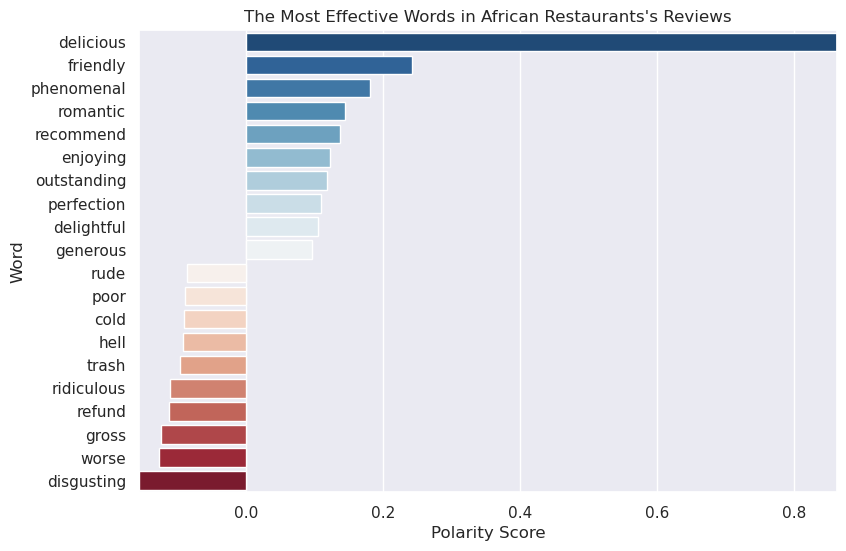

In [367]:
get_plot(african_df,'African')

StatementMeta(sparkpool, 17, 153, Finished, Available)

<Figure size 640x480 with 0 Axes>

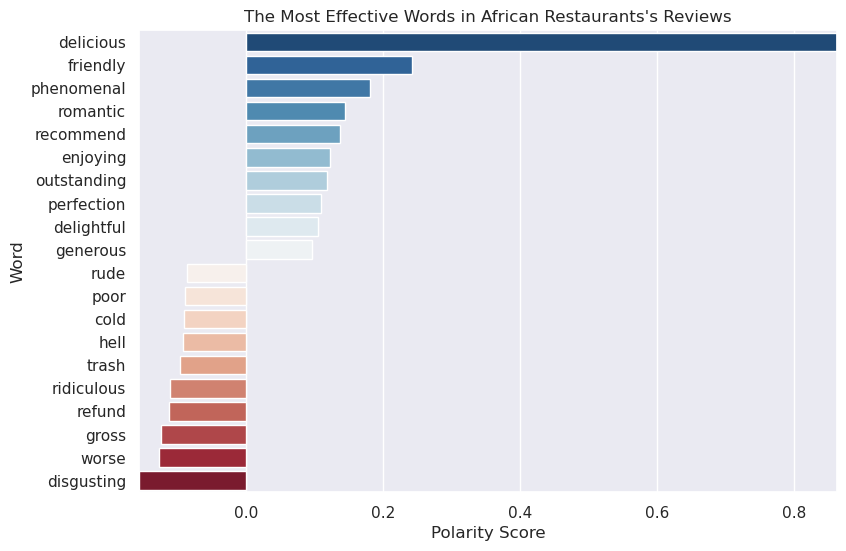

In [152]:
plt.clf()
sns.set()
sns.set_style('darkgrid')
sns.set_context('notebook')
fig,ax = plt.subplots(figsize = (9,6))
sns.barplot(data = African_concat, x = 'polarity' , y = 'word',palette = 'RdBu_r')
plt.title("The Most Effective Words in African Restaurants's Reviews")
plt.xlabel('Polarity Score')
plt.ylabel('Word')
plt.xlim(African_concat['polarity'].min(),African_concat['polarity'].max())
plt.show()